# Progetto Finale di FESI: Segmentazione di Un'immagine
***

## **Introduzione:** 
> Dato un dataset di immagini lo scopo dell'esperienza è quello di segmentare delle cellule di malaria, "separando" quindi le cellule dalla malattia

#### Quesito: Cosa costituisce una buona segmentazione?

La segmentazione è un processo di partizionamento di un'immagine digitale in diverse regioni, ognuna delle quali rappresenta un oggetto o una parte di esso presente nell'immagine stessa. Una segmentazione è considerata "buona" quando soddisfa i seguenti criteri:
- Tutti i pixel all'interno di una stessa regione dovrebbero avere **caratteristiche simili** (colore, intensità, texture) tra loro.
- Le **regioni vicine fra loro** dovrebbero essere **più diverse possibile**, in modo da evidenziare i confini degli oggetti.
- Il risultato della segmentazione dovrebbe essere abbastanza coerente con il nostro modo di percepire le varie sezioni dell'immagine.

In sostanza una segmentazione è buona quando si riesce bene a distinguere, e separare le diverse regioni di interesse in un'immagine.

## **Analisi Del Dataset:**
Per analisi del dataset si intende lo studio delle caratteristiche delle immagini presenti all'interno del dataset stesso, opzionalmente adottando anche visualizzazioni appropriate (come istogrammi), identificando quindi le sfide principali (come variazioni di colore, intensità e dimensioni) per una corretta segmentazione.

Questo è il dataset contenente tutte le 150 immagine di cellule da segmentare:
![Dataset](Dataset.png)

#### Osservazioni:
Come si può vedere vi è un gran numero di cellule che differiscono l'una dall'altra sia dalla dimensione, sia dal colore, sia dalla forma. Inoltre in quasi tutte le immagini sono visibili alcuni artefatti che confondono un po' la visione della cellula: <br> <br>
un esempio di **artefatti** possono essere alcune piccole macchie, che tuttavia sono di colore differente dalla malattia, quindi non si riesce a comprendere bene cosa siano, oppure anche lo sfondo stesso. La problematica principale di questi artefatti è che quest'ultimi potrebbero essere rimossi come parte della malattia, oppure influenzare in modo negativo la segmentazione.<br>
Ciò che si può fare è quindi sfruttare delle tecniche appropriate di pre-processing (link: cos'è il pre-processing) per filtrare correttamente le informazioni. Per esempio io durante l'analisi ho ignorato i pixel dello sfondo.

La **colorazione** delle singole cellule verrà analizzata meglio in seguito, sfruttando degli istogrammi, tuttavia possiamo già affermare con certezza che: la differenza di colore tra le varie cellule è un problema, nel caso si voglia sfruttare un algoritmo di segmentazione che fa affidamento, sull'utilizzo di una soglia fissa per identificare il colore della malattia. Posso affermare ciò perchè è proprio quello che mi è successo durante l'uso del primo metodo di segmentazione che ho provato a implementare (link al segnalibro del notebook quando avrò inserito quella parte). <br> <br>

La **dimensione** e la **forma** delle singole cellule può invece costituire un problema per algoritmi che fanno uso di forme geometriche, o comunque di identificazione dei contorni.<br>
Infatti identificare i contorni della cellula, e anche della malattia, potrebbe risultare molto complesso proprio a causa del fatto che le cellule non sono di dimensioni e forme simili fra loro, inoltre vi sono alcune immagini dove l'area della malattia non è proprio ben definita. 

### Analisi Del Dataset - Analisi Degli Istogrammi
Per analizzare meglio le colorazioni delle immagini sfrutto degli istogrammi. Inizio importando le librerie che mi serviranno durante tutto il progetto.



In [171]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import measure, morphology
import os #per poter prendere le immagini nella cartella di input e iterare 

Ovviamente non stampare gli istogrammi di tutte 150 le immagini, di conseguenza effettuo una sorta di campionamento prendendo solo alcune immagini che avranno il compito di "rappresentare" tutte le immagini con tonalità simile a quest'ultima.
Le immagini scelte sono:
- (1) 
- (14)
- (26)
- (86)
- (94)
- (110)
- (139)

Ora che ho scelto le immagini ne calcolo gli istogrammi per analizzare la distribuzione del colore all'interno dei 3 canali RGB. **Non prendo in considerazione il colore dello sfondo**

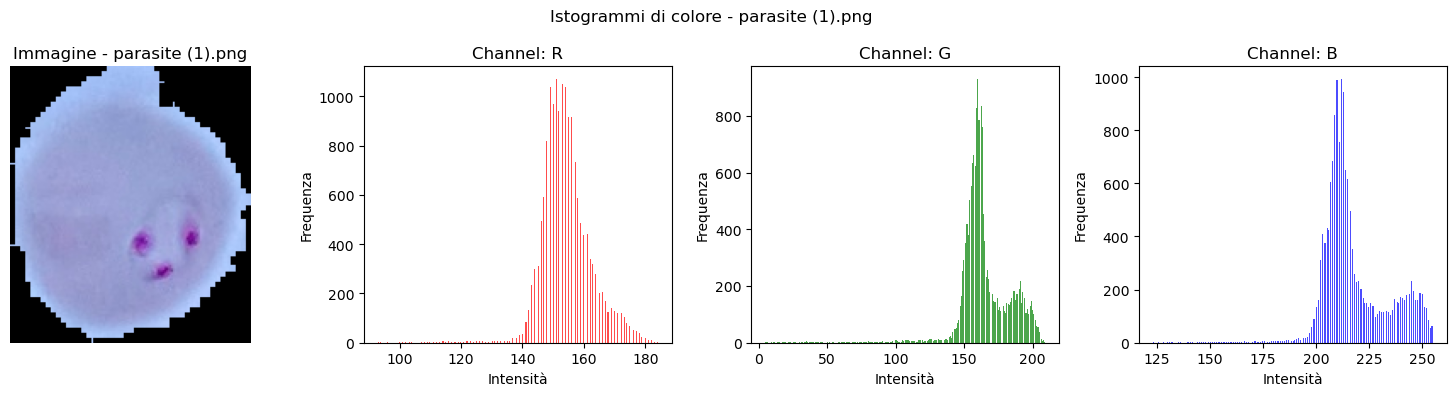

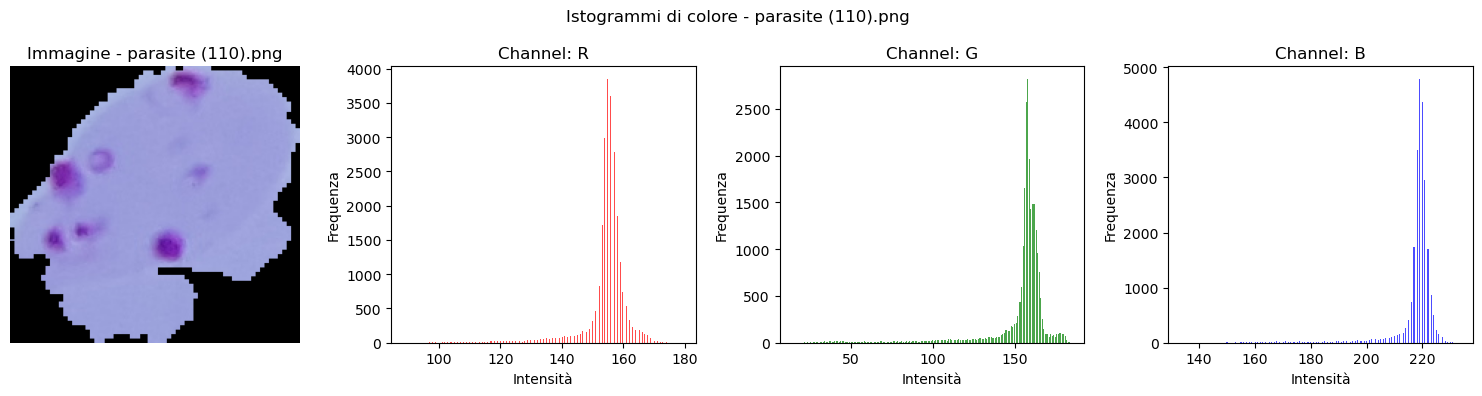

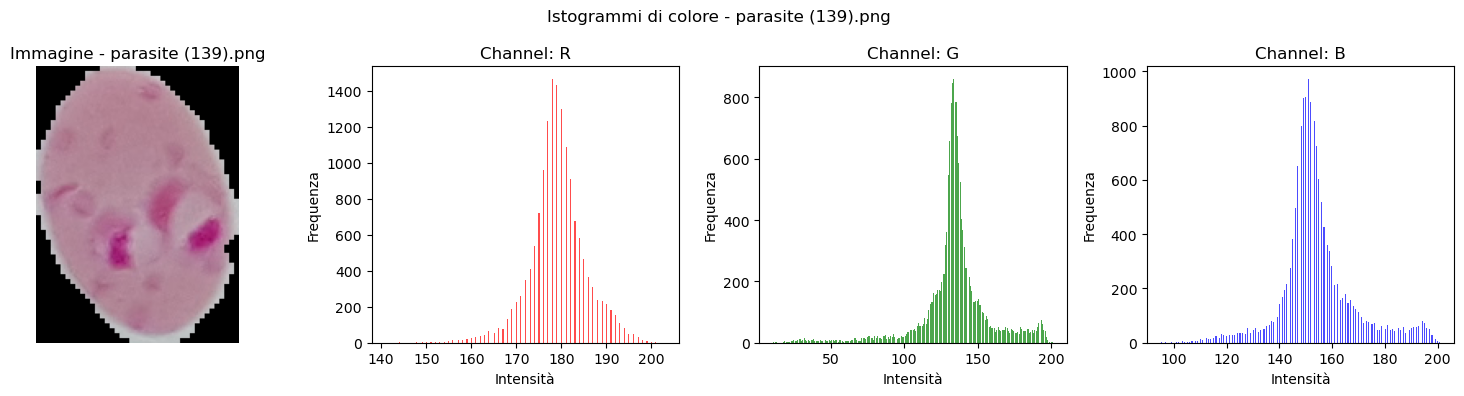

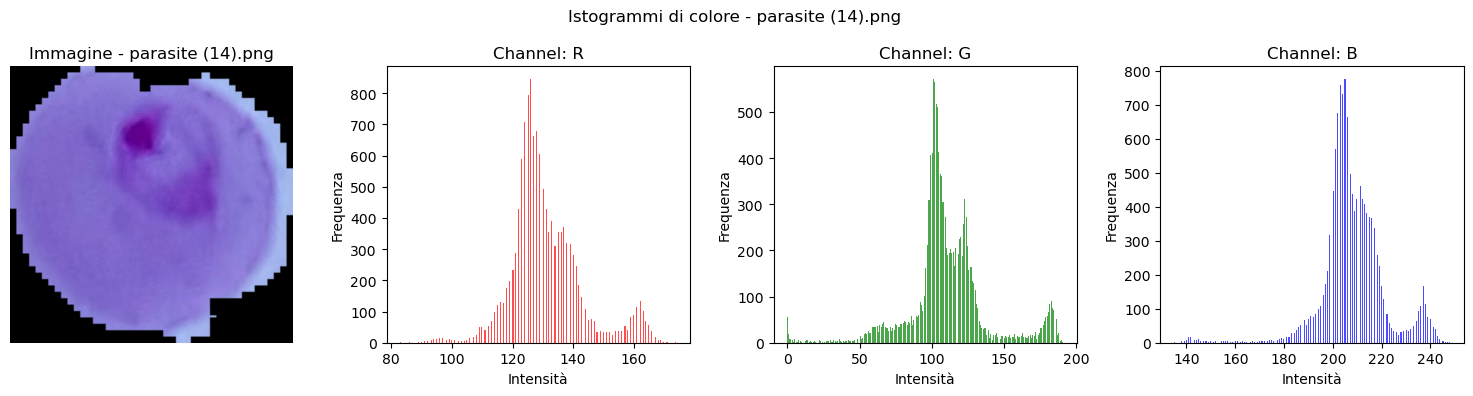

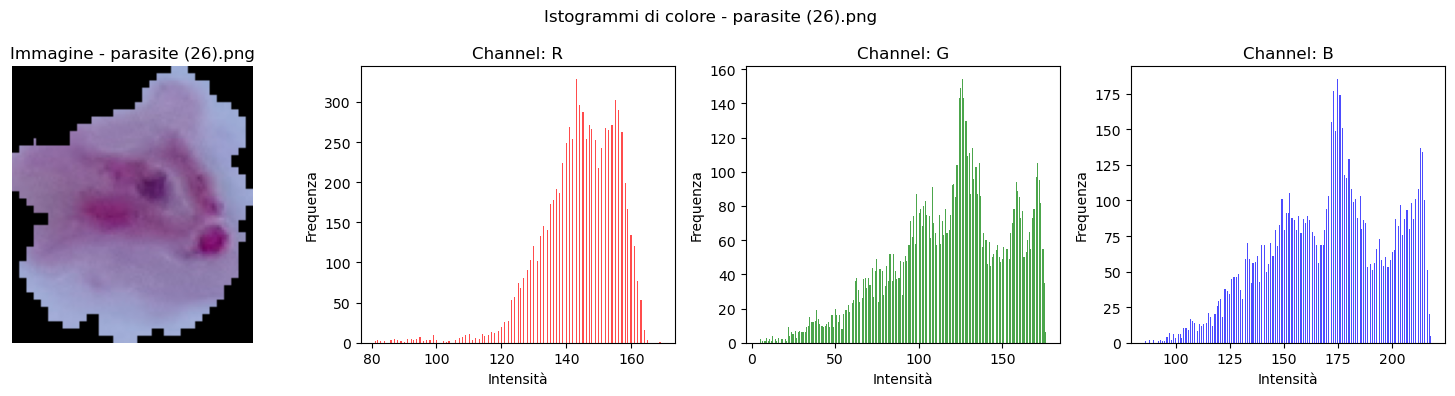

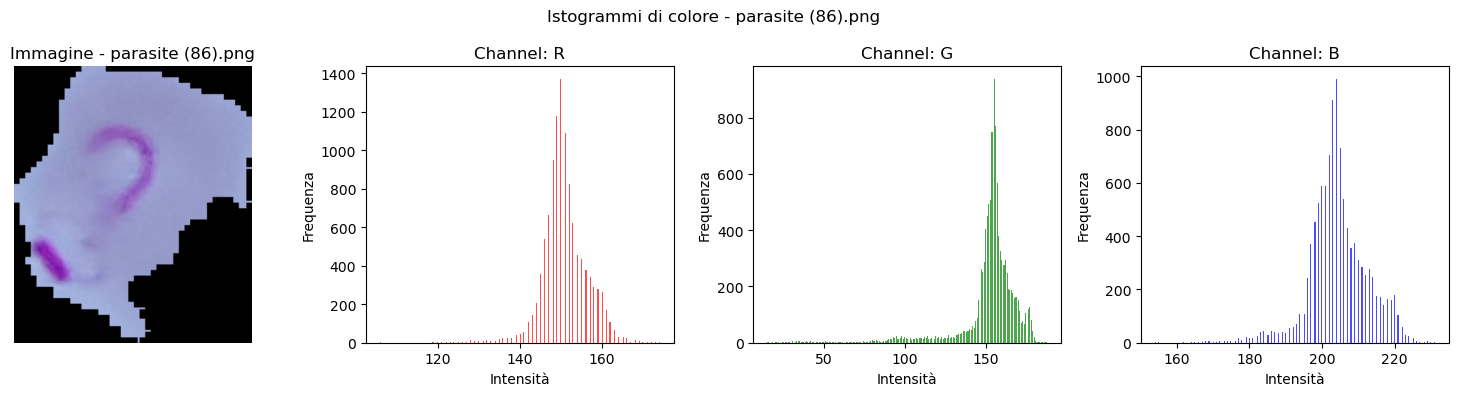

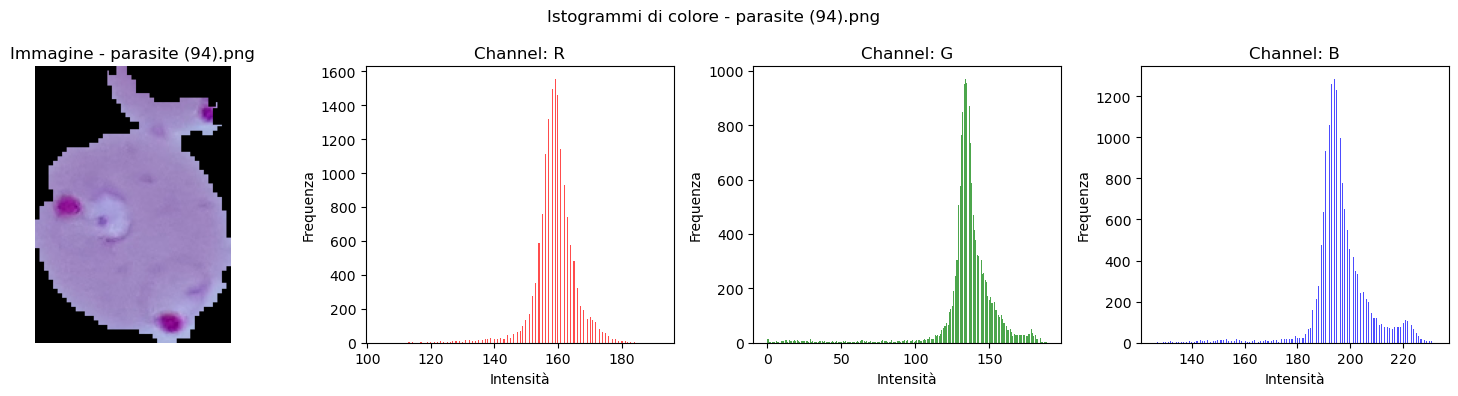

In [172]:
input_folder = 'FESI/Progetto/ImmaginiCampioni'
color_channels = ('R', 'G', 'B')

for filename in os.listdir(input_folder):
    if filename.endswith('.png') or filename.endswith('.jpg'): 
        input_path = os.path.join(input_folder, filename)
        
        image = cv2.imread(input_path)
        img_array = np.array(image)
        
        # Maschera per escludere i pixel neri (valori RGB = [0, 0, 0])
        non_black_mask = np.any(img_array > 0, axis=2)
        
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(image)
        plt.title(f"Immagine - {filename}")
        plt.axis('off')  
        
        for j, color in enumerate(color_channels):    
            # Applico la maschera per escludere i pixel neri
            channel_values = img_array[:, :, j][non_black_mask].flatten()
            
            plt.subplot(1, 4, j + 2)
            plt.hist(channel_values, bins=256, color=color.lower(), alpha=0.7)
            plt.title(f"Channel: {color}")
            plt.xlabel("Intensità")
            plt.ylabel("Frequenza")
        
        plt.suptitle(f"Istogrammi di colore - {filename}")
        plt.tight_layout()
        plt.show()


Grazie a questa analisi degli istogrammi si può notare che, le tonalità principali delle cellule sono ottenute da una combinazione di colori che prevede principalmente l'uso del rosso e del blu. <br> Infatti, anche se a primo impatto gli istogrammi sembrano equidistribuiti, sia la parte di rosso, che la parte di blu, possiedono un valore di frequenza maggiore rispetto al verde in tutte e 7 le immagini.  
Le informazioni ottenute sulla tonalità possono quindi essere utili per la progettazione di algoritmi che prevedono l'uso del colore per effettuare una buona segmentazione (come il metodo 2 che ho implementato link alla parte del notebook se si vuole già vedere).

Nonostante ciò lavorare con un immagine a colori può essere complesso a causa del maggior numero di informazioni da gestire. <br> Ecco perchè inizialmente ho scelto di lavorare con un'immagine in scala di grigi, infatti l'utilizzo di quest'ultima può semplificare l'implementazione di alcuni algoritmi di segmentazione, anche se ovviamente comporta la perdita delle informazioni relative al colore dell'immagine. 

***
## **Metodo 1: Segmentazione di un'immagine in scala di grigi tramite sogliatura**
Dopo aver analizzato il dataset delle immagini ecco la presentazione del metodo utilizzato per la segmentazione. <br>
Questo è il primo metodo che ho implementato, funziona correttamente, ma solo per alcune immagini (vedremo dopo perchè). <br>
Prima dell'analisi dell'algoritmo mi concentro sulle tecniche di pre-processing che ho scelto di sfruttare.


### Cos'è il pre-Processing - Tecniche di Pre-Processing Utilizzate
Il pre-processing è il processo attraverso cui manipoliamo i dati dell' immagine in modo tale da eliminare distorsioni indesiderate e migliorare la qualità generica dell'immagine. <br>
Quindi in generale si può dire che sto "preparando" l'immagine in modo tale da semplificarne l'analisi. <br>
Ecco alcuni esempi di tecniche di pre-processing: 
- __Resizing:__ effettuare il resizing significa modificare le dimensioni dell’immagine portandole a una dimensione uniforme. Possiamo usare OpenCV “resize”
- __Grayscaling:__ Modificare il colore di un’immagine portandola ad una scala di grigi. Ciò può semplificare i dati e ridurre il carico per alcuni algoritmi
- __Noise reduction, Normalization:__ La normalizzazione regola i valori di intensità dei pixel su un intervallo desiderato, spesso compreso tra 0 e 1. Ciò può migliorare le prestazioni dei modelli di machine learning. Applicare alcune tecniche di filtraggio (smoothing, blurring) per rimuovere del “rumore” non voluto
- __Binarization:__ Converts le immagini in scala di grigi in immagini con valori binari, ovvero bianco e nero → effettuo Thresholding
- __Miglioramento del Contrasto:__ il contrasto delle immagini può essere regolato utilizzando l'equalizzazione dell'istogramma
- __Scelta dello spazio di colore__ 

Nel mio caso le tecniche di pre-processing che son state adottate comprendono:
- Il ridimensionamento dell'immagine, in modo tale che tutte le immagini posseggano le stesse dimensioni
- Ho convertito l'immagine in scala di grigi
- Successivamente ho anche eseguito un miglioramento del contrasto tramite equalizzazione dell'istogramma 

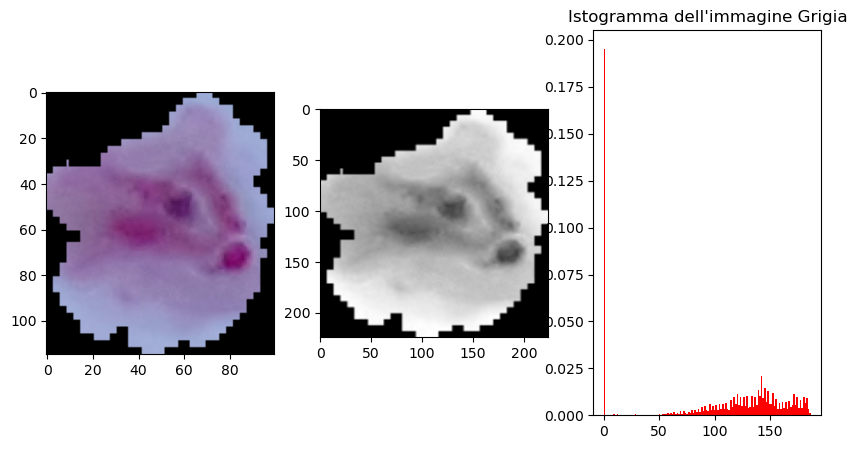

In [173]:
img = cv2.imread('FESI/Progetto/malaria/malaria/parasite (26).png', cv2.IMREAD_UNCHANGED)
resized = cv2.resize(img, (224, 224)) #ridimensionamento dell'immagine
img_gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY) # Conversione in scala di grigi

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1,3,3) 
plt.hist(img_gray.ravel(), bins=128, density=True, color='r');
plt.title("Istogramma dell'immagine Grigia")
plt.show()



Prima di effettuare il miglioramento del contrasto ho creato una maschera tramite una prima sogliatura con lo scopo di rimuovere lo sfondo nero

#### Cos'è la sogliatura (da riscrivere)?
La sogliatura (thresholding) è una tecnica utilizzata in elaborazione delle immagini per separare i pixel di un'immagine in due o più gruppi, basandosi sui loro valori di intensità. Si tratta di uno strumento fondamentale per la segmentazione delle immagini, in quanto permette di individuare regioni di interesse distinguendole dallo sfondo o da altre regioni.

Come funziona: <br>

La sogliatura si basa sull'impostazione di un valore soglia 𝑇. I pixel dell'immagine vengono classificati in base al confronto con 𝑇:
Se il valore di intensità di un pixel è maggiore o uguale a 𝑇, il pixel viene assegnato a un gruppo (es. oggetto o bianco).<br>
Se il valore di intensità di un pixel è minore di 𝑇, il pixel viene assegnato all'altro gruppo (es. sfondo o nero).

Questo processo trasforma l'immagine originale in una immagine binaria, con due soli valori, ovvero 0 e 1  (nero e bianco).

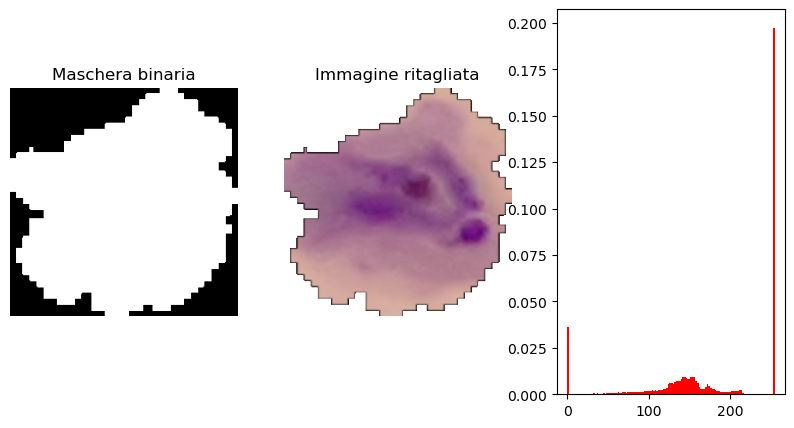

In [174]:
# Creo una maschera per rilevare il contenuto non nero
_, mask = cv2.threshold(img_gray, 10, 255, cv2.THRESH_BINARY)

resized_rgba = cv2.cvtColor(resized, cv2.COLOR_BGR2RGBA)
result = resized_rgba.copy()
result[mask == 0] = [255,255,255,0]   # Seleziono tutti i pixel che corrispondono a dove mask è 0 (quindi dove mask è nera) e li metto bianchi
 
#in questa immagine c'è un quarto valore dopo 255 perchè sto usando RGBA --> A è il canale alfa per la trasparenza


plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask, cmap='gray')
plt.title("Maschera binaria")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(result)
plt.title("Immagine ritagliata")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.hist(result.ravel(), bins=128, density=True, color='r');
plt.show()

Adesso che ho rimosso lo sfondo posso procedere con il miglioramento del contrasto. Questa tecnica viene applicata sull'immagine in scala di grigi e non sull'immagine a colori qui sopra. <br>
Il miglioramento del contrasto permette di eseguire una sogliatura piú efficace al fine di segmentare correttamente l'immagine. <br> Questo perché l'equalizzazione rende più uniforme i valori dell'istogramma, distribuendo in modo più omogeneo i livelli di grigio. Di conseguenza le zone scure diventano più scure e le zone chiare più chiare, aumentando la differenza tra le due. In questo modo i bordi tra le diverse regioni dell'immagine diventano più definiti, facilitando la loro individuazione tramite sogliatura. Tuttavia può anche capitare che, in presenza di rumore, l'equalizzazione dell'istogramma vada rendere questo rumore ancora più evidente peggiorando quindi la situazione. <br>
Infatti questo è proprio quello che è successo nel mio caso: <br> 
L'aumento del contrasto ha si definito bene i bordi, ma siccome era presente una quantità significativa di rumore lo ha amplificato. Per risolvere avrei dovuto provare ad applicare alcune tecniche di riduzione del rumore, come un filtro gaussiano o un filtro mediano.

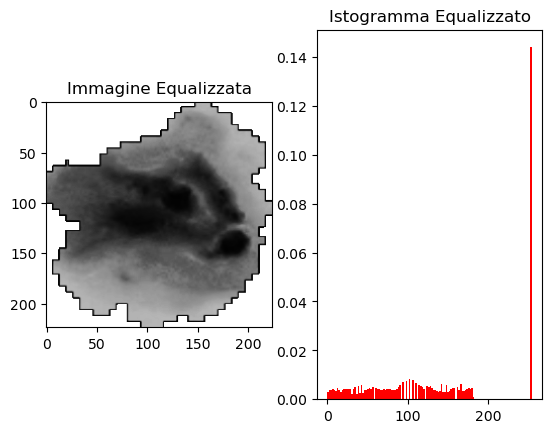

In [175]:
#Durante la conversione in scala di grigi il canale alfa (che gestisce la trasparenza) viene perso, di conseguenza lo sfondo torna al suo colore originario (io ho impostato bianco)
#Posso evitare che ciò succeda conservando il canale alfa, e riapplicandolo all'immagine convertita. 
#Tuttavia la funzione cv2.equalizeHist accetta solo immagini a un singolo canale (grayscale), di conseguenza non posso passare come argomento  un'immagine con due canali (grigio + alfa), che non perchè supportata da equalizeHist.
# Quindi effettuo prima l'equalizzazione unicamente sul canale grigio, e in seguito applico anche il canale alfa separatamente 

# Separo i quattro canali RGBA
r, g, b, alpha = cv2.split(result)

#converto l'immagine in scala di grigi + canale alfa
resultGray = cv2.cvtColor(cv2.merge((r, g, b)), cv2.COLOR_BGR2GRAY)

# Equalizzazione dell'istogramma sul canale grigio
eq_img = cv2.equalizeHist(resultGray)

# Combino il tutto con il canale alfa
bgra_gray = cv2.merge((eq_img, eq_img, eq_img, alpha))

plt.subplot(1, 2, 1)
plt.imshow(eq_img, cmap='gray')
plt.title("Immagine Equalizzata")

plt.subplot(1, 2, 2)
plt.hist(eq_img.ravel(), bins=128, density=True, color='r')
plt.title("Istogramma Equalizzato")
plt.show()

/tmp/ipykernel_901/2052373916.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  filtered_labels = morphology.remove_small_objects(labels, min_size=min_size)


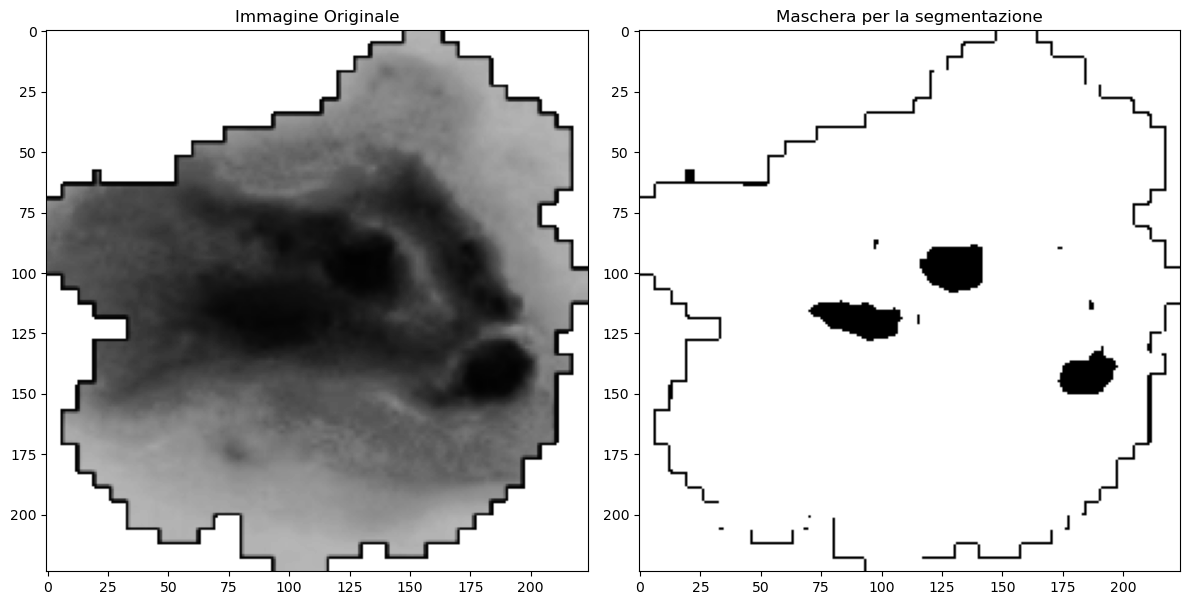

In [176]:
# Siccome non posso applicare la sogliatura sull'immagine RGBA, lavoro su un'immagine in scala di grigi e successivamente riapplico il canale alfa 
img_noRGBA = cv2.cvtColor(bgra_gray, cv2.COLOR_BGR2GRAY)

#Seconda sogliatura
_, thresh = cv2.threshold(img_noRGBA, 10, 255, cv2.THRESH_BINARY)

# Rimozione del rumore
kernel = np.ones((3,3), np.uint8) #creo il kernel di convoluzione --> matrice 3x3
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations = 2)

# Identificazione e Labeling delle regioni con lo scopo di rimuovere le regioni troppo piccole
labels = measure.label(opening, connectivity=2)  
properties = measure.regionprops(labels)
min_size = 50  # Cambia in base alle dimensioni delle macchie
filtered_labels = morphology.remove_small_objects(labels, min_size=min_size)
segmented = filtered_labels > 0  # Converti in maschera binaria

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Immagine Originale")
plt.imshow(img_noRGBA, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Maschera per la segmentazione")
plt.imshow(segmented, cmap="gray")

plt.tight_layout()
plt.show()

Tramite sogliatura ho ottenuto questa maschera, dove la parte nera dovrebbe rappresentare la malattia, ovvero l'area da rimuovere. <br>
Come avevo precedentemente annunciato purtroppo vengono rimosse anche altre aree della cellula a causa del miglioramento del contrasto, il quale mette in evidenza anche il rumore presente nella cellula. <br>

Ora che ho otttenuto la maschera vado ad applicarla all'immagine originale.

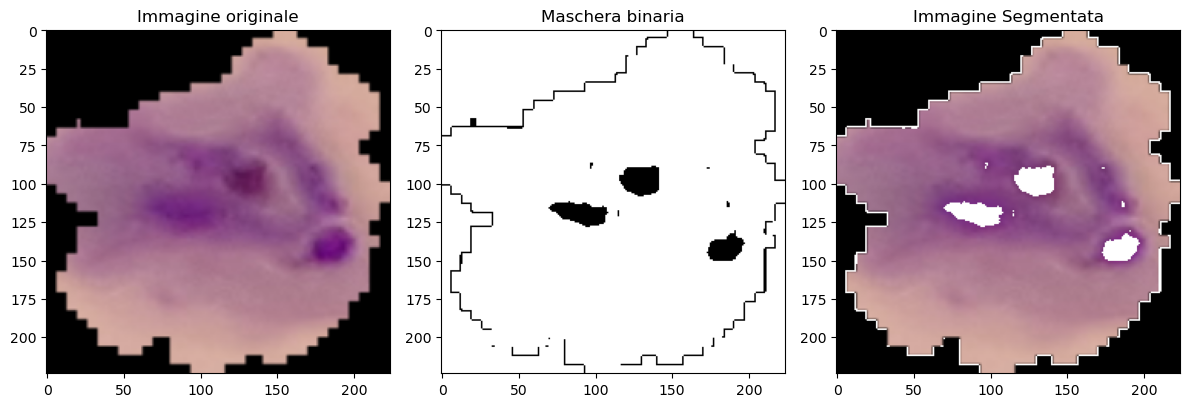

In [177]:
mask = (cv2.bitwise_not(thresh)) > 0

imgSegmented = resized.copy() #prendo una copia dell'originale sulla quale applicherò la maschera
imgSegmented[mask] = [255, 255, 255] 

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Immagine originale")
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Maschera binaria")
plt.imshow(segmented, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Immagine Segmentata")
plt.imshow(cv2.cvtColor(imgSegmented, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

Questo è il risultato della segmentazione. <br>

Testando questo codice su altre immagini del dataset possiamo notare che, oltre a non essere precisissimo, non funziona per tutte le immagini. <br>
Ciò succede a causa di due fattori principali:
1. Equalizzazione del contrasto senza rimozione del rumore, e poco accurata
2. Viene scelta una soglia fissa, e non dinamica. Quindi per far funzionare in modo efficente il codice dovrei cambiare il valore della soglia ogni volta che analizzo un'immagine diversa; oppure trovare un modo per calcolare la soglia dinamicamente.  

Farò delle considerazioni più precise sui risultati di questo algoritmo più in avanti (link se si vuole vedere subito le analisi del risultato: ). <br>
Adesso passo all'analisi del secondo metodo di segmentazione che ho implementato
<br>
***
## **Metodo 2: Segmentazione di un'immagine basandosi sull'analisi dei colori in uno spazio HSV**

Siccome non ero totalmente soddisfatto dei risultati ottenuti dal primo algoritmo ho cercato di migliorarmi implementandone un secondo che funzionasse in modo più preciso rispetto al primo <br>
Come prima scelta ho deciso di cambiare spazio di colore in cui effettuare la mia analisi, quindi di non sfruttare più una scala di grigi, ne RGB.

Questo perchè RGB non è uno spazio di colore adatto alla segmentazione. Infatti i colori vengono rappresentati come una combinazione di canali *interdipendenti* , quindi la modifica di un singolo canale va a modificare di molto anche la percezione degli altri due. Ad esempio, una variazione nella luminosità può influenzare sia il rosso che il verde e il blu, rendendo difficile separare le informazioni relative al colore da quelle relative all'illuminazione. Inoltre lo spazio RGB non è progettato per rappresentare in modo accurato la percezione umana del colore. Ad esempio, due colori che sembrano molto simili all'occhio umano possono avere valori RGB molto diversi. Ovviamente è comunque possibile effettuare una buona segmentazione, anche in RGB, ma se vogliamo facilitare e rendere più efficente la segmentazione conviene spostarci in degli spazi di colore a componente indipendente: ovvero che separano le informazioni sul colore da quelle sulla luminosità e sulla saturazione. Alcuni esempi possono essere HSV, HSL o LAB.

Personalmente ho scelto di lavorare nello spazio di colore HSV.

#### Cos'è HSV?

HSV (Hue, Saturation, Value) è uno spazio di colore che rappresenta i colori in 3 canali differenti:
- tonalità (Hue) 
- saturazione (Saturation) 
- valore (Value) <br>

Solitamente viene utilizzato questo spazio di colore perché è più intuitivo per gli esseri umani rispetto ad altri e fornisce non pochi vantaggi:

- **Separazione della tonalità**: In HSV, la tonalità è separata dalla saturazione e dalla luminosità, il che rende più semplice isolare specifici colori. Ciò viene fatto anche in altri spazi di colore come LAB, tuttavia in quest'ultimo i componenti a e b rappresentano i colori in modo meno intuitivo, di conseguenza sono più complessi da utilizzare per la segmentazione basata sui colori.

- **Maggiore Utilizzo**: HSV è ampiamente utilizzato in molte applicazioni pratiche di elaborazione delle immagini.

Quindi dopo aver fatto alcuni tentativi sia con HSV sia con LAB mi sono trovato a lavorare meglio con HSV    (DEFINIZIONE DA RIVEDERE E MIGLIORARE)

### Definizione dell'algoritmo

Tramite l'analisi degli istogrammi che abbiamo fatto precedente 


1. aggiungere pre-prossing al codice che funziona
2. aggiungere post - processing al codice che funziona
3. Controllare per quali immagini funziona il metodo 1 con soglia a 10
  